# Energy prices downloaded from AEMO


[aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem/aggregated-data](https://aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem/aggregated-data)

In [55]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import seaborn as sns
import sklearn.cluster as cluster
import time
#from pandas_profiling import ProfileReport

import statsmodels.api as sm
import statsmodels.formula.api as smf

import math

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from matplotlib.pyplot import errorbar

# Specifing figure layout
%matplotlib inline
# plt.style.use('fivethirtyeight')
# sns.set_color_codes('bright')
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.rcParams["figure.figsize"] = (15, 10)

## First have a look at the raw data

In [2]:
pd_nsw_12_01 = pd.read_csv('../data/aemo/price_and_demand/PRICE_AND_DEMAND_201201_NSW1.csv', 
        parse_dates=['SETTLEMENTDATE'])

In [3]:
pd_nsw_12_01.head()

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2012-01-01 00:30:00,6976.86,24.51,TRADE
1,NSW1,2012-01-01 01:00:00,6796.47,23.05,TRADE
2,NSW1,2012-01-01 01:30:00,6494.43,22.49,TRADE
3,NSW1,2012-01-01 02:00:00,6271.40,18.02,TRADE
4,NSW1,2012-01-01 02:30:00,6107.27,17.90,TRADE


In [4]:
pd_nsw_12_01['DAY'] = pd_nsw_12_01['SETTLEMENTDATE'].dt.date

In [5]:
pd_DAY_avg = pd_nsw_12_01.groupby('DAY').mean()
pd_DAY_avg.head()

,TOTALDEMAND,RRP
DAY,,
2012-01-01,7118.604681,24.044894
2012-01-02,7560.392708,27.658333
2012-01-03,8761.376250,31.912500
2012-01-04,9035.712292,24.598542
2012-01-05,8390.441250,23.501875


<AxesSubplot:xlabel='DAY', ylabel='TOTALDEMAND'>

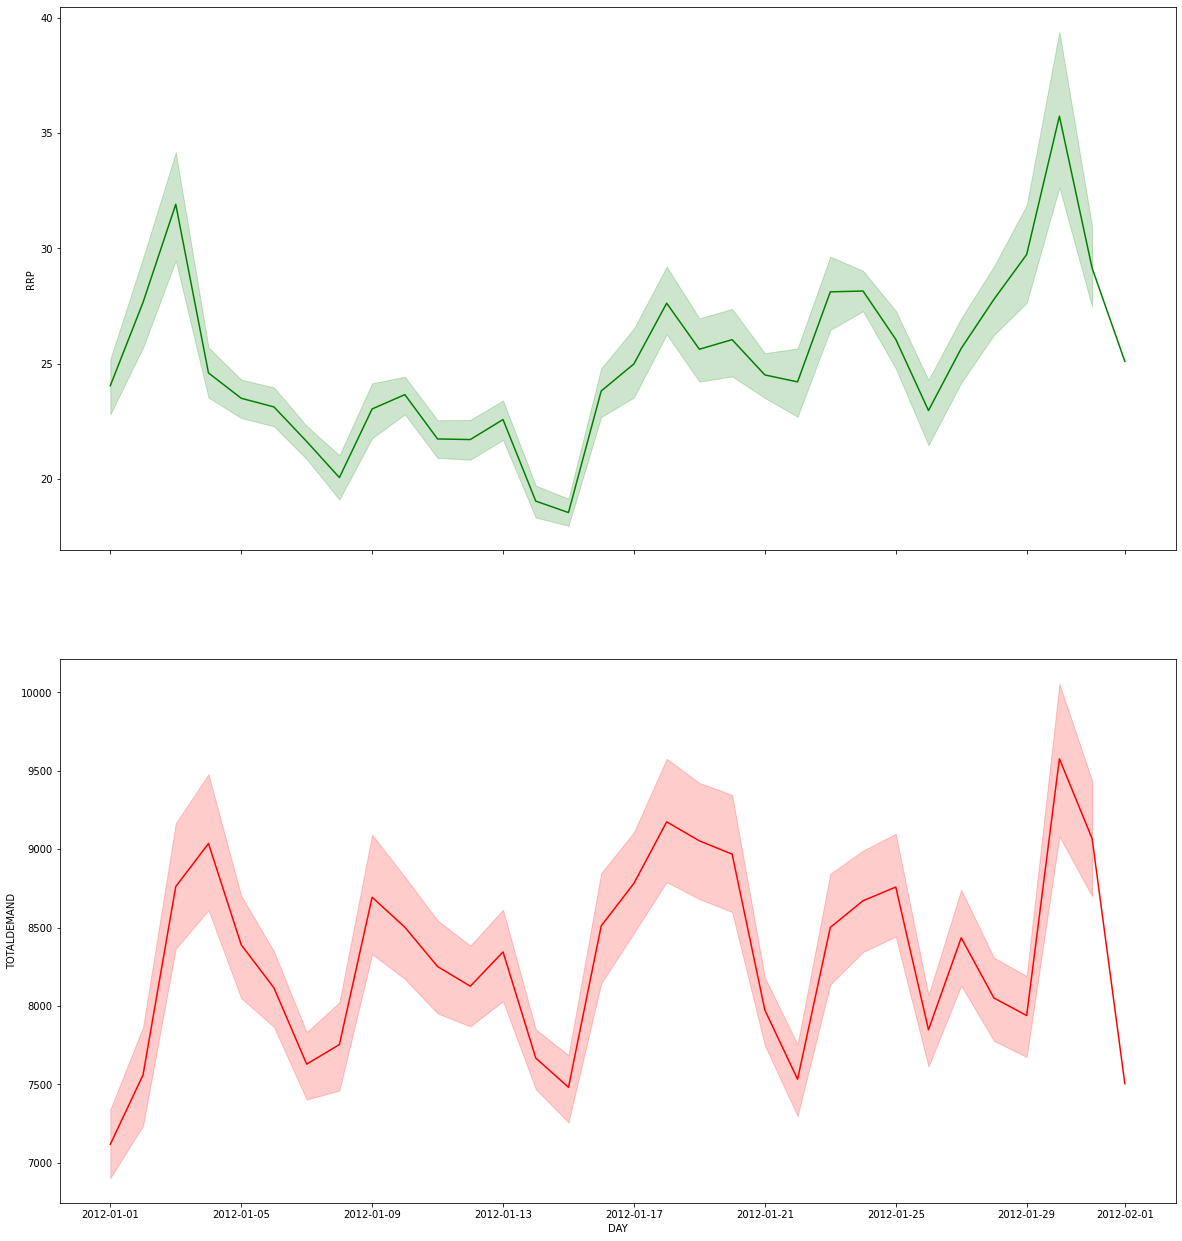

In [6]:
# Plot daily average
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,22), sharex=True)#, sharey=True)
axs = axs.ravel()
sns.lineplot(data=pd_nsw_12_01, x='DAY', y='RRP', ax=axs[0], color='green')
sns.lineplot(data=pd_nsw_12_01, x='DAY', y='TOTALDEMAND', ax=axs[1], color='red')

<AxesSubplot:xlabel='SETTLEMENTDATE', ylabel='TOTALDEMAND'>

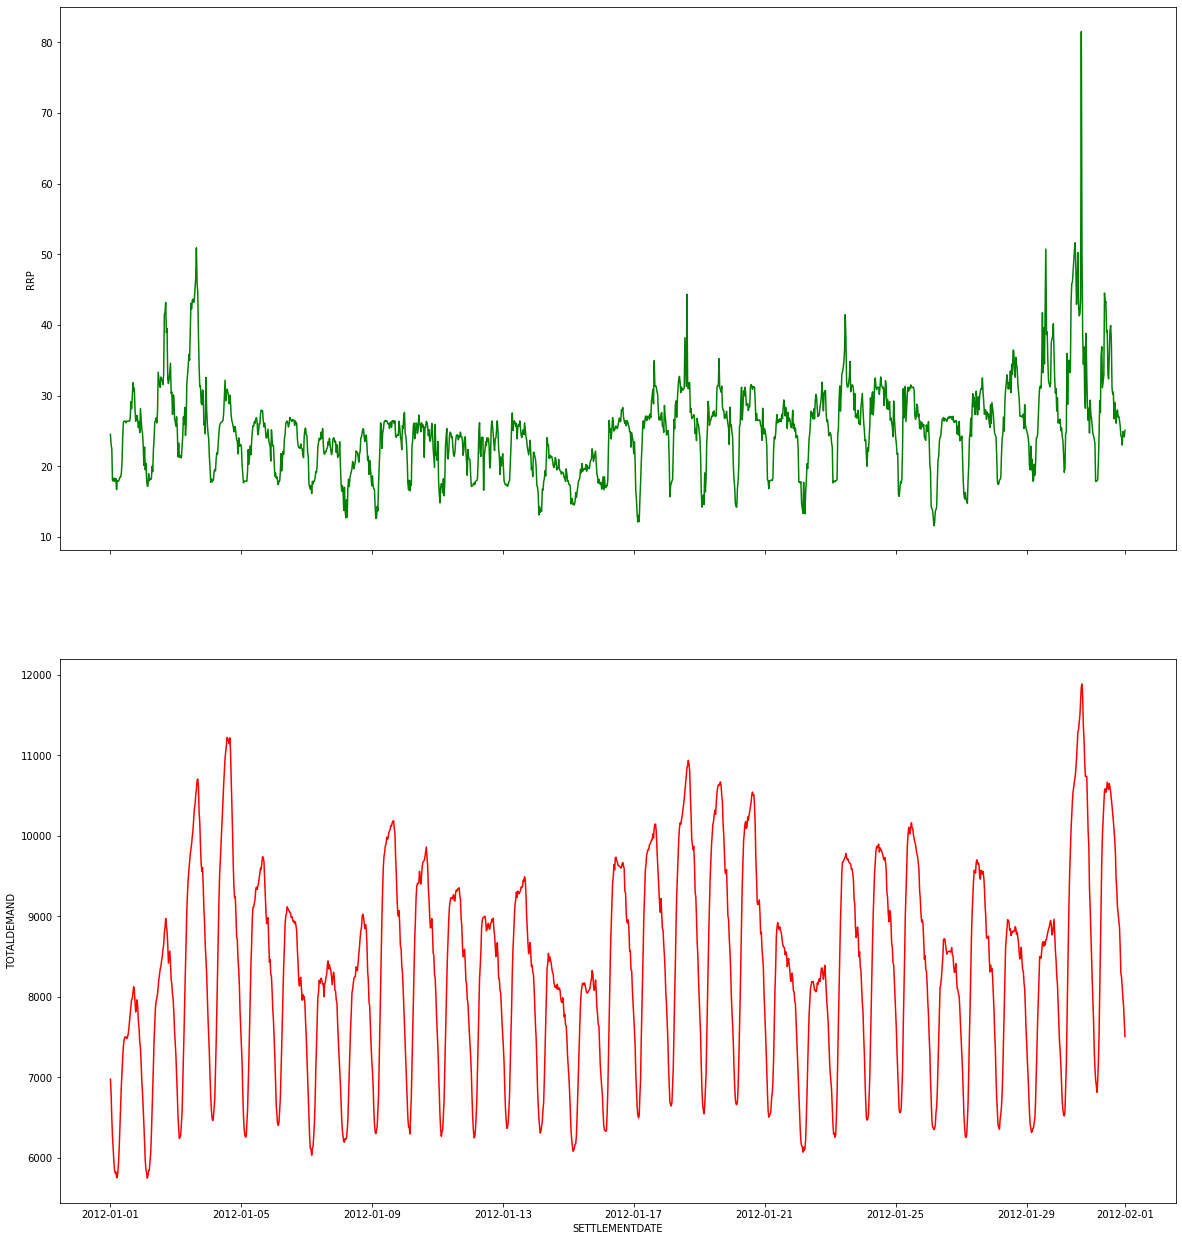

In [7]:
# Plot half-hour data
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,22), sharex=True)#, sharey=True)
axs = axs.ravel()
sns.lineplot(data=pd_nsw_12_01, x='SETTLEMENTDATE', y='RRP', ax=axs[0], color='green')
sns.lineplot(data=pd_nsw_12_01, x='SETTLEMENTDATE', y='TOTALDEMAND', ax=axs[1], color='red')

## Load all data. Take the average of one DAY and also average over all states.

In [8]:
year = range(2012,2014)
month = range(1,13)
state = ['NSW', 'QLD', 'VIC', 'SA', 'TAS']
pc = 'PRICE_AND_DEMAND'

In [9]:
pd_all = pd.DataFrame(columns=pd_nsw_12_01.columns)
for st in state:
    for yy in year:
        for mm in month:
            pc = 'PRICE_AND_DEMAND'
            file_name = pc+'_'+str(yy)+str(mm).zfill(2)+'_'+st+'1.csv'
            tmp = pd.read_csv('../data/aemo/price_and_demand/'+file_name, 
                    parse_dates=['SETTLEMENTDATE'])
            pd_all = pd.concat([pd_all, tmp], axis=0, join='outer')
pd_all['DAY'] = pd_all['SETTLEMENTDATE'].dt.date

In [10]:
pd_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175440 entries, 0 to 1487
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          175440 non-null  object        
 1   SETTLEMENTDATE  175440 non-null  datetime64[ns]
 2   TOTALDEMAND     175440 non-null  float64       
 3   RRP             175440 non-null  float64       
 4   PERIODTYPE      175440 non-null  object        
 5   DAY             175440 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 9.4+ MB


In [11]:
pd_all

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE,DAY
0,NSW1,2012-01-01 00:30:00,6976.86,24.51,TRADE,2012-01-01
1,NSW1,2012-01-01 01:00:00,6796.47,23.05,TRADE,2012-01-01
2,NSW1,2012-01-01 01:30:00,6494.43,22.49,TRADE,2012-01-01
3,NSW1,2012-01-01 02:00:00,6271.40,18.02,TRADE,2012-01-01
4,NSW1,2012-01-01 02:30:00,6107.27,17.90,TRADE,2012-01-01
...,...,...,...,...,...,...
1483,TAS1,2013-12-31 22:00:00,1034.41,34.32,TRADE,2013-12-31
1484,TAS1,2013-12-31 22:30:00,1005.48,34.32,TRADE,2013-12-31
1485,TAS1,2013-12-31 23:00:00,962.69,34.28,TRADE,2013-12-31
1486,TAS1,2013-12-31 23:30:00,954.62,36.29,TRADE,2013-12-31


In [12]:
pd_all

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE,DAY
0,NSW1,2012-01-01 00:30:00,6976.86,24.51,TRADE,2012-01-01
1,NSW1,2012-01-01 01:00:00,6796.47,23.05,TRADE,2012-01-01
2,NSW1,2012-01-01 01:30:00,6494.43,22.49,TRADE,2012-01-01
3,NSW1,2012-01-01 02:00:00,6271.40,18.02,TRADE,2012-01-01
4,NSW1,2012-01-01 02:30:00,6107.27,17.90,TRADE,2012-01-01
...,...,...,...,...,...,...
1483,TAS1,2013-12-31 22:00:00,1034.41,34.32,TRADE,2013-12-31
1484,TAS1,2013-12-31 22:30:00,1005.48,34.32,TRADE,2013-12-31
1485,TAS1,2013-12-31 23:00:00,962.69,34.28,TRADE,2013-12-31
1486,TAS1,2013-12-31 23:30:00,954.62,36.29,TRADE,2013-12-31


In [32]:
pd_all_mean = pd_all.groupby('DAY').mean()[['TOTALDEMAND', 'RRP']]
pd_all_mean.columns = [cc+'_mean' for cc in pd_all_mean.columns]
pd_all_max = pd_all.groupby('DAY').max()[['TOTALDEMAND', 'RRP']]
pd_all_max.columns = [cc+'_max' for cc in pd_all_max.columns]
pd_all_min = pd_all.groupby('DAY').min()[['TOTALDEMAND', 'RRP']]
pd_all_min.columns = [cc+'_min' for cc in pd_all_min.columns]
pd_all_mean.head()
pd_all_daily = pd.concat([pd_all_mean, pd_all_max, pd_all_min], axis=1)

# make features
pd_all_daily = pd_all_daily.assign(RRP_ratio_max_mean = lambda x : x['RRP_max'] / x['RRP_mean'])
pd_all_daily = pd_all_daily.assign(TOTALDEMAND_ratio_max_mean = lambda x : x['TOTALDEMAND_max'] /
                                                                     x['TOTALDEMAND_mean'])
pd_all_daily = pd_all_daily.assign(RRP_ratio_min_mean = lambda x : x['RRP_min'] / x['RRP_mean'])
pd_all_daily = pd_all_daily.assign(TOTALDEMAND_ratio_min_mean = lambda x : x['TOTALDEMAND_min'] /
                                                                     x['TOTALDEMAND_mean'])

# add a rolling average
pd_all_daily[['TOTALDEMAND_mean_rolling3','RRP_mean_rolling3']] = \
                            pd_all_daily[['TOTALDEMAND_mean', 'RRP_mean']]\
                            .rolling(window=3, min_periods=1).mean()
pd_all_daily = pd_all_daily.assign(TOTALDEMAND_ratio_rolling_mean = \
                                lambda x : x['TOTALDEMAND_mean_rolling3'] / x['TOTALDEMAND_mean'])
pd_all_daily = pd_all_daily.assign(RRP_ratio_rolling_mean = \
                                lambda x : x['RRP_mean_rolling3'] / x['RRP_mean'])
# pd_all_daily.info()
# pd_all_daily.head()
ratios_price_totaldemand = pd_all_daily[['RRP_ratio_max_mean', 'RRP_ratio_min_mean', 
                                'TOTALDEMAND_ratio_max_mean', 'TOTALDEMAND_ratio_min_mean',
                                'RRP_mean_rolling3', 'TOTALDEMAND_mean_rolling3']]
ratios_price_totaldemand.head()

,RRP_ratio_max_mean,RRP_ratio_min_mean,TOTALDEMAND_ratio_max_mean,TOTALDEMAND_ratio_min_mean,RRP_mean_rolling3,TOTALDEMAND_mean_rolling3
DAY,,,,,,
2012-01-01,2.833451,0.418241,1.971340,0.198934,28.332936,4121.319021
2012-01-02,1.888420,0.483000,2.051924,0.173431,29.311406,4247.292844
2012-01-03,2.014632,0.614699,2.223403,0.184126,30.760520,4436.349549
2012-01-04,2.633071,0.598807,2.468363,0.183184,29.655014,4577.758625
2012-01-05,2.265400,0.571573,2.201436,0.224668,28.014583,4594.843750


No handles with labels found to put in legend.


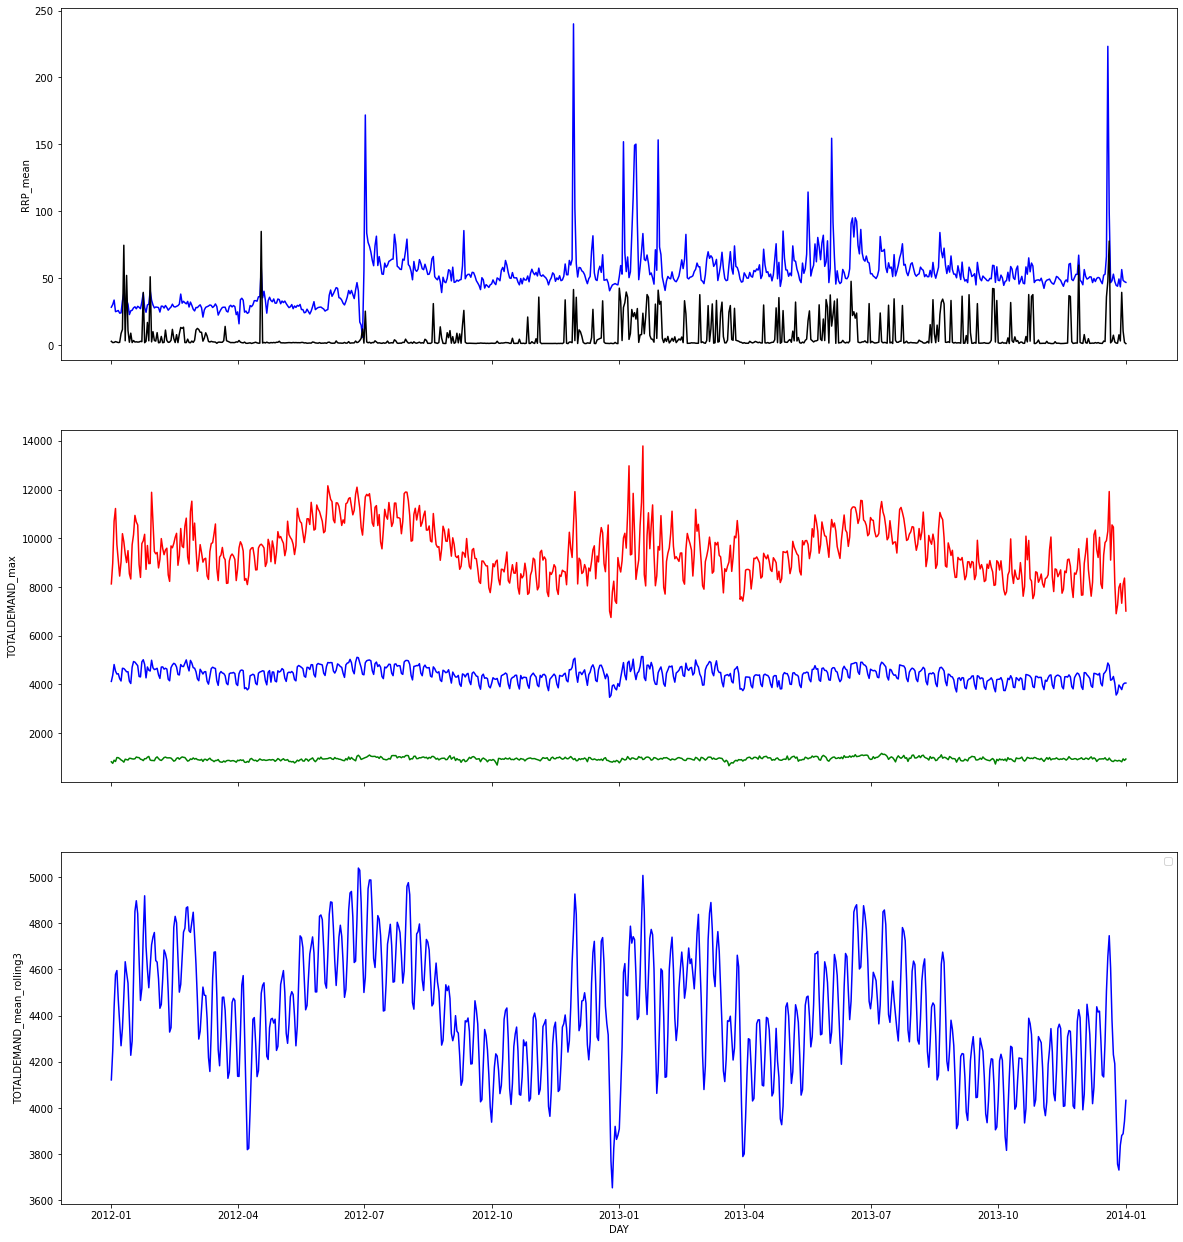

In [33]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20,22), sharex=True)#, sharey=True)
axs = axs.ravel()
#sns.lineplot(data=pd_all_daily, x='DAY', y='RRP_max', ax=axs[0], color='red')
sns.lineplot(data=pd_all_daily, x='DAY', y='RRP_mean', ax=axs[0], color='blue')
#sns.lineplot(data=pd_all_daily, x='DAY', y='RRP_min', ax=axs[0], color='green')
sns.lineplot(data=pd_all_daily, x='DAY', y='RRP_ratio_max_mean', ax=axs[0], color='black')
sns.lineplot(data=pd_all_daily, x='DAY', y='TOTALDEMAND_max', ax=axs[1], color='red')
sns.lineplot(data=pd_all_daily, x='DAY', y='TOTALDEMAND_mean', ax=axs[1], color='blue')
sns.lineplot(data=pd_all_daily, x='DAY', y='TOTALDEMAND_min', ax=axs[1], color='green')
#sns.lineplot(data=pd_all_daily, x='DAY', y='RRP_mean_rolling3', ax=axs[3], color='red')
sns.lineplot(data=pd_all_daily, x='DAY', y='TOTALDEMAND_mean_rolling3', ax=axs[2], color='blue')
plt.legend()

In [37]:
pd_all_daily.columns
pd_all_daily = pd_all_daily[['TOTALDEMAND_mean', 'RRP_mean', 'TOTALDEMAND_max', 'RRP_max',
       'TOTALDEMAND_min', 'RRP_min', 'RRP_ratio_max_mean',
       'TOTALDEMAND_ratio_max_mean', 'RRP_ratio_min_mean',
       'TOTALDEMAND_ratio_min_mean', 'TOTALDEMAND_mean_rolling3',
       'RRP_mean_rolling3', 'TOTALDEMAND_ratio_rolling_mean',
       'RRP_ratio_rolling_mean']]

## Now use this data to predict the energy output

In [109]:
df = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data_incl_features.csv', parse_dates=['TIMESTAMP'])
df.TARGETVAR = df.TARGETVAR.fillna(0)

In [110]:
df.head()

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,IS_HOLIDAY,WS10,WS100,WD10,WD100,WD100CARD,WD10CARD,U100NORM,V100NORM
0,1,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076,1,1,6,1,3.421530,4.652334,321.614439,321.999735,NW,NW,0.615665,-0.788008
1,1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761,2,1,6,1,3.096451,4.154892,305.473680,306.385781,NW,NW,0.805041,-0.593219
2,1,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093,3,1,6,1,2.795932,3.712577,287.108562,289.088098,WNW,WNW,0.945017,-0.327022
3,1,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546,4,1,6,1,2.461699,3.234831,273.345160,276.310236,W,W,0.993941,-0.109912
4,1,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701,5,1,6,1,2.279435,2.976332,260.159324,263.581938,W,W,0.993733,0.111782


In [111]:
df['DAY'] = df['TIMESTAMP'].dt.date

In [112]:
# Now merge the dataset and the energy prices.
# But: The energy prices have to to be shifted, since we can only use the energy prices of the day ahead
pd_all_daily_shifted = pd_all_daily.shift(+1)
# ratios_price_totaldemand_shifted = ratios_price_totaldemand.shift(+1)

df = df.merge(pd_all_daily_shifted, on='DAY')
# df = df.merge(ratios_price_totaldemand_shifted, on='DAY')
df.dropna(axis=0, inplace=True)

In [91]:
df = pd.get_dummies(df, columns=['WD100CARD'], drop_first=True)

In [113]:
target = 'TARGETVAR'
features = [feat for feat in df.columns.to_list() if not (feat in [target, 'TIMESTAMP', 'WD100CARD', 'WD10CARD', 'DAY'])]

X = pd.DataFrame(df[features])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state= 42)

In [114]:
zones = df.ZONEID.unique()

zone_X_train = {zone: X_train[X_train.ZONEID == zone] for zone in zones}
zone_X_test = {zone: X_test[X_test.ZONEID == zone] for zone in zones}
zone_y_train = {zone: y_train[X_train.ZONEID == zone] for zone in zones}
zone_y_test = {zone: y_test[X_test.ZONEID == zone] for zone in zones}

results = {}

y_pred_all = np.array([])
y_pred_idx = np.array([], dtype = 'int')

zone_y_train[1]

for zone in zones:
    model = LinearRegression()
    model.fit(zone_X_train[zone], zone_y_train[zone])
    y_pred = model.predict(zone_X_test[zone])
    y_pred = [1 if value > 1 else 0 if value < 0 else value for value in y_pred]
    results["ZONE" + str(zone)] = mean_squared_error(zone_y_test[zone], y_pred, squared=False)
    y_pred_all = np.concatenate([y_pred_all, y_pred], axis = 0)
    y_pred_idx = np.concatenate([y_pred_idx, zone_X_test[zone].index], axis = 0)

y_pred_all
y_pred_idx

print(mean_squared_error(y_test[y_pred_idx], y_pred_all, squared=False))

0.1761406829192246


Without energy prices:\
0.17570275736217736\
\
With energy prices of day before:\
0.1761406829192246

ZONE1
	train:	 0.07390209384768716
	test:	 0.13637522052054954
ZONE2
	train:	 0.057480937478238
	test:	 0.11665226681354157
ZONE3
	train:	 0.062379594167067204
	test:	 0.1247427464249416
ZONE4
	train:	 0.07907695385812501
	test:	 0.1456918156383955
ZONE5
	train:	 0.07641240437886289
	test:	 0.1478305974790649
ZONE6
	train:	 0.07856059244944533
	test:	 0.1499824192282925
ZONE7
	train:	 0.05363079378776353
	test:	 0.10904248661506391
ZONE8
	train:	 0.06482213201222282
	test:	 0.13143546019710933
ZONE9
	train:	 0.06647396627872737
	test:	 0.13293429975998025
ZONE10
	train:	 0.08463338994309441
	test:	 0.16545549477789623
train:  0.07042966730202221
test:  0.13687331271662007


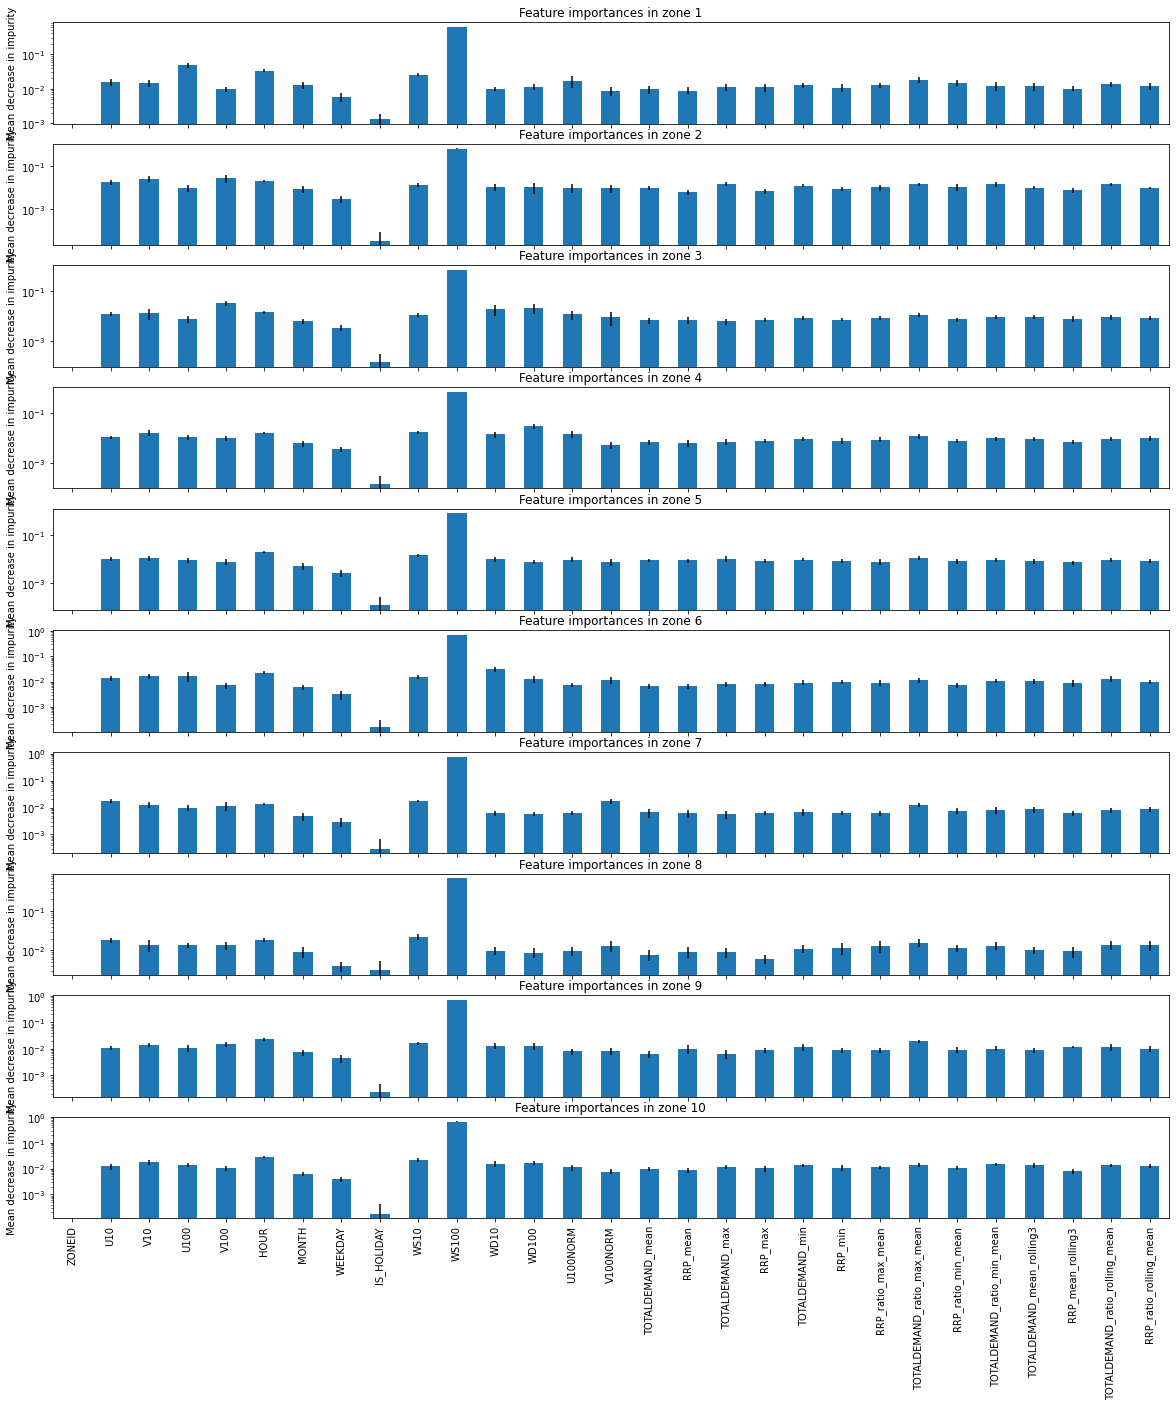

In [115]:
zones = df.ZONEID.unique()

zone_X_train = {zone: X_train[X_train.ZONEID == zone] for zone in zones}
zone_X_test = {zone: X_test[X_test.ZONEID == zone] for zone in zones}
zone_y_train = {zone: y_train[X_train.ZONEID == zone] for zone in zones}
zone_y_test = {zone: y_test[X_test.ZONEID == zone] for zone in zones}

results = {}
results_train = {}

y_pred_all = np.array([])
y_pred_idx = np.array([], dtype = 'int')
y_pred_all_train = np.array([])
y_pred_idx_train = np.array([], dtype = 'int')

fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20,22), sharex=True)#, sharey=True)
axs = axs.ravel()

for zone in zones:
    model = RandomForestRegressor(n_estimators=15, max_depth=15, n_jobs=-1)
    model.fit(zone_X_train[zone], zone_y_train[zone])
    y_pred_train = model.predict(zone_X_train[zone])
    y_pred_train = [1 if value > 1 else 0 if value < 0 else value for value in y_pred_train]
    results_train["ZONE" + str(zone)] = mean_squared_error(zone_y_train[zone], y_pred_train, squared=False)
    y_pred_all_train = np.concatenate([y_pred_all_train, y_pred_train], axis = 0)
    y_pred_idx_train = np.concatenate([y_pred_idx_train, zone_X_train[zone].index], axis = 0)
    y_pred = model.predict(zone_X_test[zone])
    y_pred = [1 if value > 1 else 0 if value < 0 else value for value in y_pred]
    results["ZONE" + str(zone)] = mean_squared_error(zone_y_test[zone], y_pred, squared=False)
    y_pred_all = np.concatenate([y_pred_all, y_pred], axis = 0)
    y_pred_idx = np.concatenate([y_pred_idx, zone_X_test[zone].index], axis = 0)
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=features)
    forest_importances.plot.bar(yerr=std, ax=axs[zone-1])
    axs[zone-1].set_title(f"Feature importances in zone {zone}")
    axs[zone-1].set_ylabel("Mean decrease in impurity")
    axs[zone-1].set_yscale('log')


y_pred_all
y_pred_idx

for k in results_train.keys():
    print(k)
    print('\ttrain:\t', results_train[k])
    print('\ttest:\t', results[k])

print('train: ', mean_squared_error(y_train[y_pred_idx_train], y_pred_all_train, squared=False))
print('test: ', mean_squared_error(y_test[y_pred_idx], y_pred_all, squared=False))


Without energy prices:\
0.15331508543718533\
\
With energy prices of day before:\
0.13687331271662007

## Now that we have seen that it somehow increases the forecast, we can try to make the plot the connection between energy output and demand

In [47]:
df[features].iloc[100:150]
features_day = features.copy()
features_day.append('DAY')
df[features_day].groupby('DAY').mean()

,ZONEID,U10,V10,U100,V100,HOUR,MONTH,WEEKDAY,IS_HOLIDAY,WS10,...,TOTALDEMAND_min,RRP_min,RRP_ratio_max_mean,TOTALDEMAND_ratio_max_mean,RRP_ratio_min_mean,TOTALDEMAND_ratio_min_mean,TOTALDEMAND_mean_rolling3,RRP_mean_rolling3,TOTALDEMAND_ratio_rolling_mean,RRP_ratio_rolling_mean
DAY,,,,,,,,,,,,,,,,,,,,,
2012-01-02,5.5,1.171590,-0.045158,1.621157,0.338244,11.5,1.0,0.0,0.0,3.844483,...,819.87,11.85,2.833451,1.971340,0.418241,0.198934,4121.319021,28.332936,1.000000,1.000000
2012-01-03,5.5,1.740122,2.164717,2.700884,3.245576,11.5,1.0,1.0,0.0,4.375250,...,758.46,14.63,1.888420,2.051924,0.483000,0.173431,4247.292844,29.311406,0.971195,0.967696
2012-01-04,5.5,-1.036773,3.448110,-1.959285,5.127128,11.5,1.0,2.0,0.0,4.019633,...,886.47,20.69,2.014632,2.223403,0.614699,0.184126,4436.349549,30.760520,0.921463,0.913894
2012-01-05,5.5,-1.359716,2.676894,-2.396637,4.091595,11.5,1.0,3.0,0.0,4.072027,...,832.67,14.98,2.633071,2.468363,0.598807,0.183184,4577.758625,29.655014,1.007087,1.185422
2012-01-06,5.5,-0.996915,-2.017264,-1.590016,-3.768766,11.5,1.0,4.0,0.0,3.420012,...,994.05,14.50,2.265400,2.201436,0.571573,0.224668,4594.843750,28.014583,1.038495,1.104302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-28,5.5,1.277107,3.923007,1.690699,6.129386,11.5,12.0,5.0,0.0,5.833810,...,879.22,26.28,7.694148,2.007975,0.531635,0.221283,3731.114931,46.043681,0.939052,0.931448
2013-12-29,5.5,-1.756595,1.605740,-3.046195,2.498960,11.5,12.0,6.0,0.0,3.206126,...,856.18,17.30,3.100283,2.095452,0.397502,0.220398,3838.561917,45.656722,0.988125,1.049053
2013-12-30,5.5,-0.265801,1.475162,-0.776105,2.479879,11.5,12.0,0.0,0.0,2.819090,...,820.57,24.02,39.414017,1.936706,0.425450,0.216836,3880.751083,49.804014,1.025492,0.882145


In [ ]:
# Binning the 

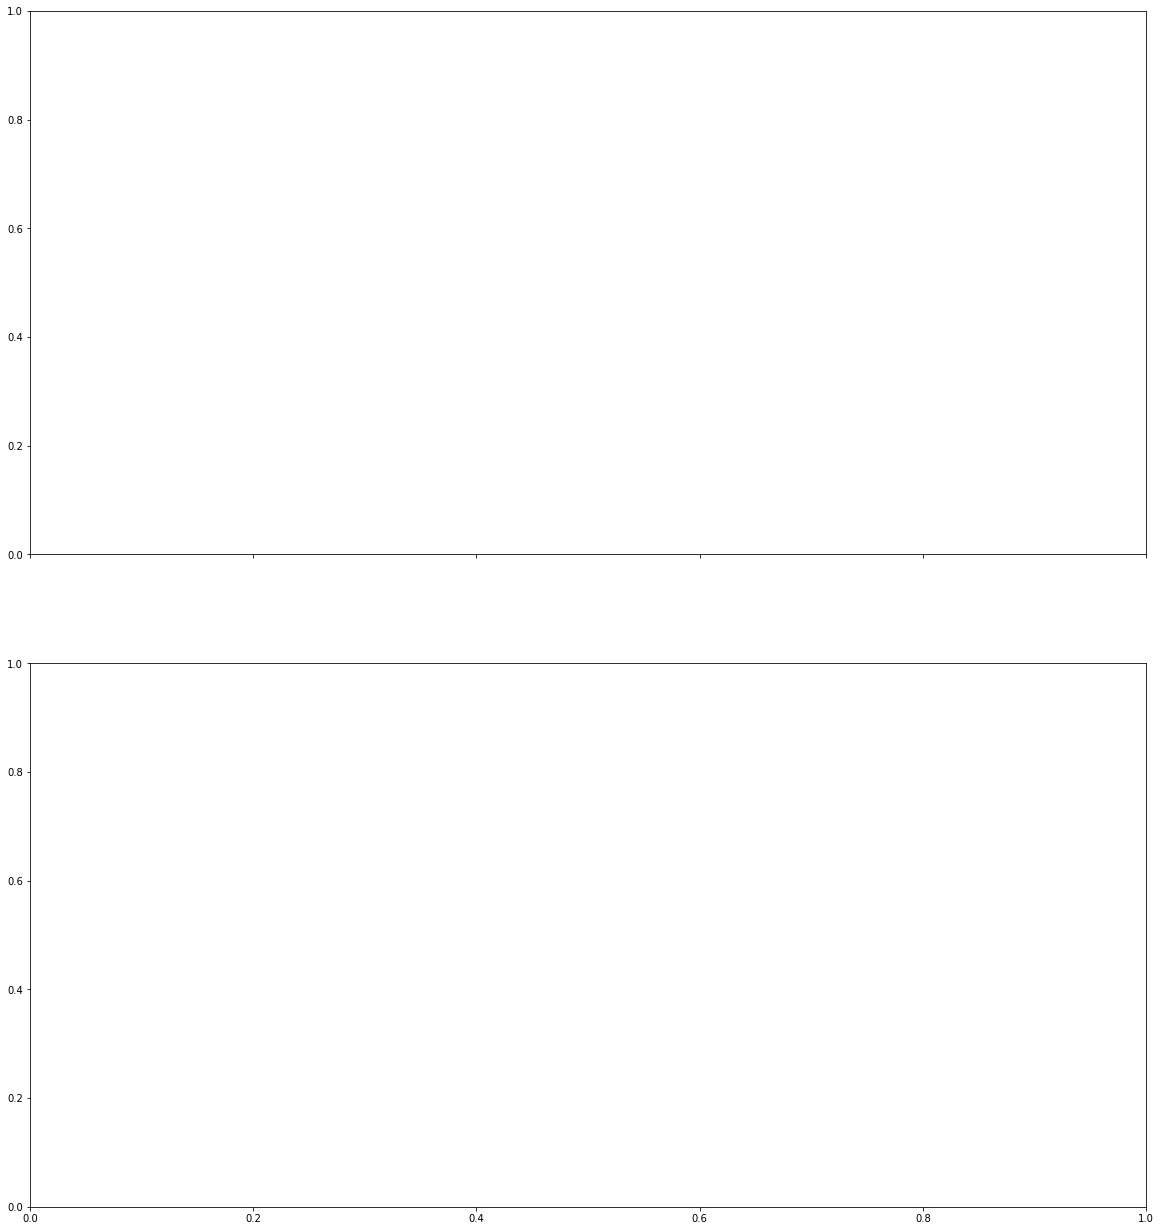

In [49]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,22), sharex=True)#, sharey=True)
axs = axs.ravel()

# pmm = df['PRICE_max_mean']
# pmm.min()
# sorted(pmm)
#len(pmm)
#pmm.max()
# pmm = pmm.apply(lambda x : math.log(abs(x)))
# sns.histplot(pmm)
#df['PRICE_max_mean'].hist(bins=20, xscale='log')